# Regressionsmodell: Quadratmeterpreis vs. Endbestand

Dieses Notebook erstellt ein Regressionsmodell zur Vorhersage von `ds10200_quadratmeterpreis_chf` basierend auf `ds10680_endbestand`.

## 1. Import erforderlicher Bibliotheken

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import statsmodels.api as sm
from scipy import stats
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set style for visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## 2. Daten laden

In [2]:
# Daten laden
df = pd.read_csv('/workspaces/ARM_Gruppe-5/data/ARM_Master_Table_final.csv')

# Relevant Spalten wählen
columns = ['ds10200_quadratmeterpreis_chf', 'ds10680_endbestand']
df_model = df[columns].copy()

print("Datensatz geladen:")
print(f"Form: {df_model.shape}")
print(f"\nErstellt 5 Zeilen:")
print(df_model.head())

Datensatz geladen:
Form: (144, 2)

Erstellt 5 Zeilen:
   ds10200_quadratmeterpreis_chf  ds10680_endbestand
0                          319.0                2299
1                            0.0                2344
2                            0.0                2318
3                          379.0                2330
4                            0.0                2319


## 3. Datenüberblick & Bereinigung

In [3]:
# Info über Datensatz
print("Dateninfo:")
print(df_model.info())
print("\n" + "="*50 + "\n")

# Beschreibende Statistik
print("Beschreibende Statistik:")
print(df_model.describe())
print("\n" + "="*50 + "\n")

# Konvertiere zu numerisch mit error handling
df_model['ds10200_quadratmeterpreis_chf'] = pd.to_numeric(df_model['ds10200_quadratmeterpreis_chf'], errors='coerce')
df_model['ds10680_endbestand'] = pd.to_numeric(df_model['ds10680_endbestand'], errors='coerce')

# Fehler Werte Check
print(f"Fehlende Werte:")
print(df_model.isnull().sum())
print("\n" + "="*50 + "\n")

# Entferne NaN-Werte
df_model_clean = df_model.dropna(subset=['ds10200_quadratmeterpreis_chf', 'ds10680_endbestand'])

print(f"Datensatz nach Bereinigung: {df_model_clean.shape}")
print(f"Entfernte Zeilen: {df_model.shape[0] - df_model_clean.shape[0]}")

Dateninfo:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   ds10200_quadratmeterpreis_chf  144 non-null    float64
 1   ds10680_endbestand             144 non-null    int64  
dtypes: float64(1), int64(1)
memory usage: 2.4 KB
None


Beschreibende Statistik:
       ds10200_quadratmeterpreis_chf  ds10680_endbestand
count                     144.000000          144.000000
mean                      564.736111        23954.270833
std                       664.655755        24193.627759
min                         0.000000         1680.000000
25%                         0.000000         4493.250000
50%                       349.000000         8389.500000
75%                      1062.500000        37001.000000
max                      2708.000000        73159.000000


Fehlende Werte:
ds10200_quadratmeterpreis_chf   

## 4. Explorative Datenanalyse (EDA)

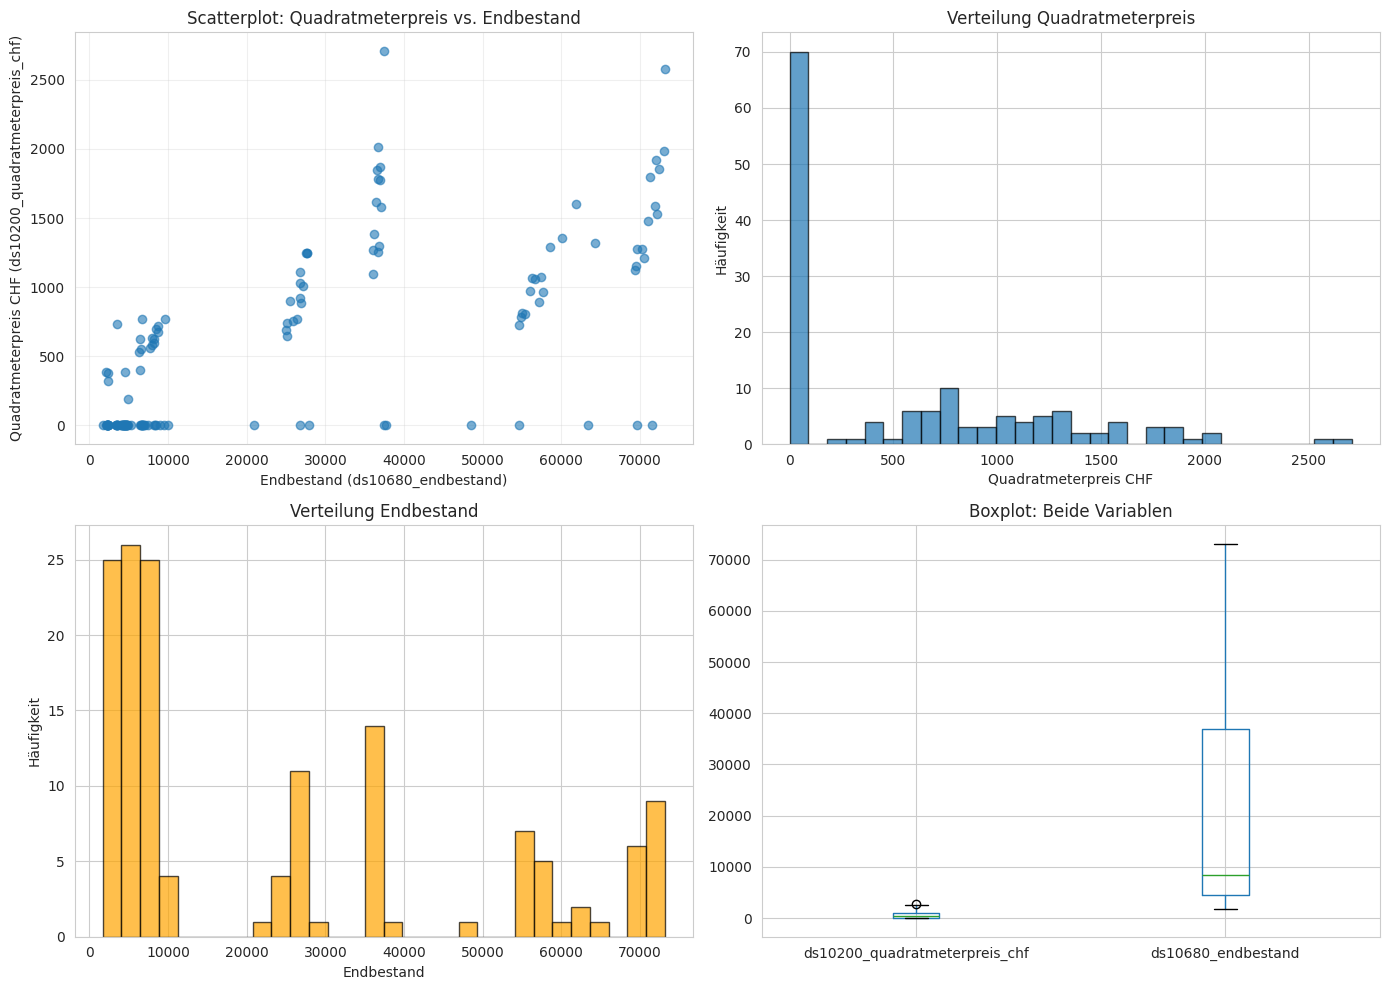



Pearson-Korrelation: 0.7002
Pearson-Korrelationskoeffizient: 0.7002
P-Wert: 1.5784e-22
Signifikant: Ja


In [4]:
# Scatterplot
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Scatterplot
axes[0, 0].scatter(df_model_clean['ds10680_endbestand'], 
                    df_model_clean['ds10200_quadratmeterpreis_chf'], alpha=0.6)
axes[0, 0].set_xlabel('Endbestand (ds10680_endbestand)')
axes[0, 0].set_ylabel('Quadratmeterpreis CHF (ds10200_quadratmeterpreis_chf)')
axes[0, 0].set_title('Scatterplot: Quadratmeterpreis vs. Endbestand')
axes[0, 0].grid(True, alpha=0.3)

# Histogramm Zielwert
axes[0, 1].hist(df_model_clean['ds10200_quadratmeterpreis_chf'], bins=30, edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Quadratmeterpreis CHF')
axes[0, 1].set_ylabel('Häufigkeit')
axes[0, 1].set_title('Verteilung Quadratmeterpreis')

# Histogramm Prädiktor
axes[1, 0].hist(df_model_clean['ds10680_endbestand'], bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[1, 0].set_xlabel('Endbestand')
axes[1, 0].set_ylabel('Häufigkeit')
axes[1, 0].set_title('Verteilung Endbestand')

# Boxplot
df_model_clean.boxplot(ax=axes[1, 1])
axes[1, 1].set_title('Boxplot: Beide Variablen')

plt.tight_layout()
plt.show()

print("\n" + "="*50 + "\n")

# Korrelation berechnen
correlation = df_model_clean['ds10200_quadratmeterpreis_chf'].corr(df_model_clean['ds10680_endbestand'])
pearson_r, p_value = stats.pearsonr(df_model_clean['ds10200_quadratmeterpreis_chf'], 
                                      df_model_clean['ds10680_endbestand'])

print(f"Pearson-Korrelation: {correlation:.4f}")
print(f"Pearson-Korrelationskoeffizient: {pearson_r:.4f}")
print(f"P-Wert: {p_value:.4e}")
print(f"Signifikant: {'Ja' if p_value < 0.05 else 'Nein'}")

## 5. Feature Engineering

In [5]:
# Prüfe auf Ausreißer und ggf. Transformationen
print("Originalwerte:")
print(f"Quadratmeterpreis - Min: {df_model_clean['ds10200_quadratmeterpreis_chf'].min()}, "
      f"Max: {df_model_clean['ds10200_quadratmeterpreis_chf'].max()}")
print(f"Endbestand - Min: {df_model_clean['ds10680_endbestand'].min()}, "
      f"Max: {df_model_clean['ds10680_endbestand'].max()}")

# Erstelle Feature: Log-Transformationen (optional für bessere Linearität)
df_model_clean['log_quadratmeterpreis'] = np.log1p(df_model_clean['ds10200_quadratmeterpreis_chf'])
df_model_clean['log_endbestand'] = np.log1p(df_model_clean['ds10680_endbestand'])

# Vergleich der Korrelationen
corr_original = df_model_clean['ds10200_quadratmeterpreis_chf'].corr(df_model_clean['ds10680_endbestand'])
corr_log = df_model_clean['log_quadratmeterpreis'].corr(df_model_clean['log_endbestand'])

print(f"\nKorrelation (Original): {corr_original:.4f}")
print(f"Korrelation (Log-transformiert): {corr_log:.4f}")

# Entferne Nullwerte für Preis (> 0)
df_model_clean = df_model_clean[df_model_clean['ds10200_quadratmeterpreis_chf'] > 0]
print(f"\nDatensatz nach Ausreißer-Entfernung (Preis > 0): {df_model_clean.shape}")

Originalwerte:
Quadratmeterpreis - Min: 0.0, Max: 2708.0
Endbestand - Min: 1680, Max: 73159

Korrelation (Original): 0.7002
Korrelation (Log-transformiert): 0.6527

Datensatz nach Ausreißer-Entfernung (Preis > 0): (74, 4)


## 6. Train-/Test-Split

In [6]:
# Vorbereitung für Modellierung
# Verwende Original-Werte
X = df_model_clean[['ds10680_endbestand']].values
y = df_model_clean['ds10200_quadratmeterpreis_chf'].values

# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training-Set Größe: {X_train.shape[0]}")
print(f"Test-Set Größe: {X_test.shape[0]}")
print(f"Train/Test Ratio: {X_train.shape[0] / X_test.shape[0]:.2f}")

Training-Set Größe: 59
Test-Set Größe: 15
Train/Test Ratio: 3.93


## 7. Lineares Regressionsmodell (Baseline)

In [7]:
# Trainiere lineares Regressionsmodell
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Koeffizienten
print("Lineares Regressionsmodell")
print("="*50)
print(f"Modellgleichung: y = β₀ + β₁*x + ε")
print(f"Intercept (β₀): {lr_model.intercept_:.4f}")
print(f"Koeffizient (β₁): {lr_model.coef_[0]:.6f}")

print("\nInterpretation:")
print(f"- Pro 1 Einheit Endbestand-Erhöhung steigt Preis um {lr_model.coef_[0]:.4f} CHF/m²")

# Vorhersagen auf Testset
y_pred_lr = lr_model.predict(X_test)

print(f"\nVorhersagen auf Test-Set (erste 10):")
print(f"{'Tatsächlich':<12} {'Vorhersage':<12} {'Fehler':<12}")
for i in range(min(10, len(y_test))):
    error = y_test[i] - y_pred_lr[i]
    print(f"{y_test[i]:<12.2f} {y_pred_lr[i]:<12.2f} {error:<12.2f}")

Lineares Regressionsmodell
Modellgleichung: y = β₀ + β₁*x + ε
Intercept (β₀): 610.4168
Koeffizient (β₁): 0.013818

Interpretation:
- Pro 1 Einheit Endbestand-Erhöhung steigt Preis um 0.0138 CHF/m²

Vorhersagen auf Test-Set (erste 10):
Tatsächlich  Vorhersage   Fehler      
622.00       698.67       -76.67      
768.00       975.02       -207.02     
2011.00      1118.05      892.95      
319.00       642.18       -323.18     
675.00       730.32       -55.32      
389.00       672.35       -283.35     
1388.00      1110.93      277.07      
809.00       1375.77      -566.77     
1252.00      1116.97      135.03      
1854.00      1610.80      243.20      


## 8. Regularisierte Modelle (Ridge & Lasso)

In [8]:
# Ridge Regression (alpha=1.0)
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_test)

# Lasso Regression (alpha=0.1)
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train, y_train)
y_pred_lasso = lasso_model.predict(X_test)

print("Ridge & Lasso Modelle")
print("="*50)
print(f"\nRidge (alpha=1.0):")
print(f"  Intercept: {ridge_model.intercept_:.4f}")
print(f"  Koeffizient: {ridge_model.coef_[0]:.6f}")

print(f"\nLasso (alpha=0.1):")
print(f"  Intercept: {lasso_model.intercept_:.4f}")
print(f"  Koeffizient: {lasso_model.coef_[0]:.6f}")

# Vergleich der Koeffizienten
print(f"\nKoeffizientenvergleich:")
print(f"{'Modell':<20} {'Koeffizient':<15}")
print("-" * 35)
print(f"{'Linear Regression':<20} {lr_model.coef_[0]:<15.6f}")
print(f"{'Ridge':<20} {ridge_model.coef_[0]:<15.6f}")
print(f"{'Lasso':<20} {lasso_model.coef_[0]:<15.6f}")

Ridge & Lasso Modelle

Ridge (alpha=1.0):
  Intercept: 610.4168
  Koeffizient: 0.013818

Lasso (alpha=0.1):
  Intercept: 610.4168
  Koeffizient: 0.013818

Koeffizientenvergleich:
Modell               Koeffizient    
-----------------------------------
Linear Regression    0.013818       
Ridge                0.013818       
Lasso                0.013818       


## 9. Hyperparameter-Tuning (GridSearchCV)

In [9]:
# GridSearchCV für Ridge
alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

# Ridge Tuning
ridge_grid = GridSearchCV(Ridge(), param_grid={'alpha': alphas}, cv=5, scoring='r2')
ridge_grid.fit(X_train, y_train)

# Lasso Tuning
lasso_grid = GridSearchCV(Lasso(max_iter=10000), param_grid={'alpha': alphas}, cv=5, scoring='r2')
lasso_grid.fit(X_train, y_train)

print("GridSearchCV Ergebnisse")
print("="*50)
print(f"\nRidge - Beste Alpha: {ridge_grid.best_params_['alpha']}")
print(f"Ridge - Beste CV-Score (R²): {ridge_grid.best_score_:.4f}")

print(f"\nLasso - Beste Alpha: {lasso_grid.best_params_['alpha']}")
print(f"Lasso - Beste CV-Score (R²): {lasso_grid.best_score_:.4f}")

# Verwende beste Modelle für Vorhersagen
best_ridge_model = ridge_grid.best_estimator_
best_lasso_model = lasso_grid.best_estimator_

y_pred_ridge_best = best_ridge_model.predict(X_test)
y_pred_lasso_best = best_lasso_model.predict(X_test)

print(f"\nBeste Ridge Modell - Koeffizient: {best_ridge_model.coef_[0]:.6f}")
print(f"Beste Lasso Modell - Koeffizient: {best_lasso_model.coef_[0]:.6f}")

GridSearchCV Ergebnisse

Ridge - Beste Alpha: 1000
Ridge - Beste CV-Score (R²): 0.3411

Lasso - Beste Alpha: 1000
Lasso - Beste CV-Score (R²): 0.3411

Beste Ridge Modell - Koeffizient: 0.013818
Beste Lasso Modell - Koeffizient: 0.013816


## 10. Modellbewertung & Metriken

In [10]:
# Modellbewertung auf Test-Set
def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    return {
        'Modell': model_name,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2
    }

# Evaluiere alle Modelle
results = []
results.append(evaluate_model(y_test, y_pred_lr, 'Linear Regression'))
results.append(evaluate_model(y_test, y_pred_ridge, 'Ridge (alpha=1.0)'))
results.append(evaluate_model(y_test, y_pred_lasso, 'Lasso (alpha=0.1)'))
results.append(evaluate_model(y_test, y_pred_ridge_best, f'Ridge (best, alpha={ridge_grid.best_params_["alpha"]})'))
results.append(evaluate_model(y_test, y_pred_lasso_best, f'Lasso (best, alpha={lasso_grid.best_params_["alpha"]})'))

# Erstelle Ergebnis-DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('R²', ascending=False)

print("Modellbewertung - Test-Set Metriken")
print("="*80)
print(results_df.to_string(index=False))
print("\n" + "="*80)
print(f"\nBestes Modell: {results_df.iloc[0]['Modell']}")
print(f"R²-Score: {results_df.iloc[0]['R²']:.4f}")
print(f"RMSE: {results_df.iloc[0]['RMSE']:.2f} CHF/m²")
print(f"MAE: {results_df.iloc[0]['MAE']:.2f} CHF/m²")

Modellbewertung - Test-Set Metriken
                  Modell       RMSE        MAE       R²
       Linear Regression 385.453260 310.560726 0.390439
       Ridge (alpha=1.0) 385.453260 310.560726 0.390439
       Lasso (alpha=0.1) 385.453261 310.560728 0.390439
Ridge (best, alpha=1000) 385.453261 310.560730 0.390439
Lasso (best, alpha=1000) 385.456111 310.577827 0.390430


Bestes Modell: Linear Regression
R²-Score: 0.3904
RMSE: 385.45 CHF/m²
MAE: 310.56 CHF/m²


## 11. Residuenanalyse & Annahmenprüfung

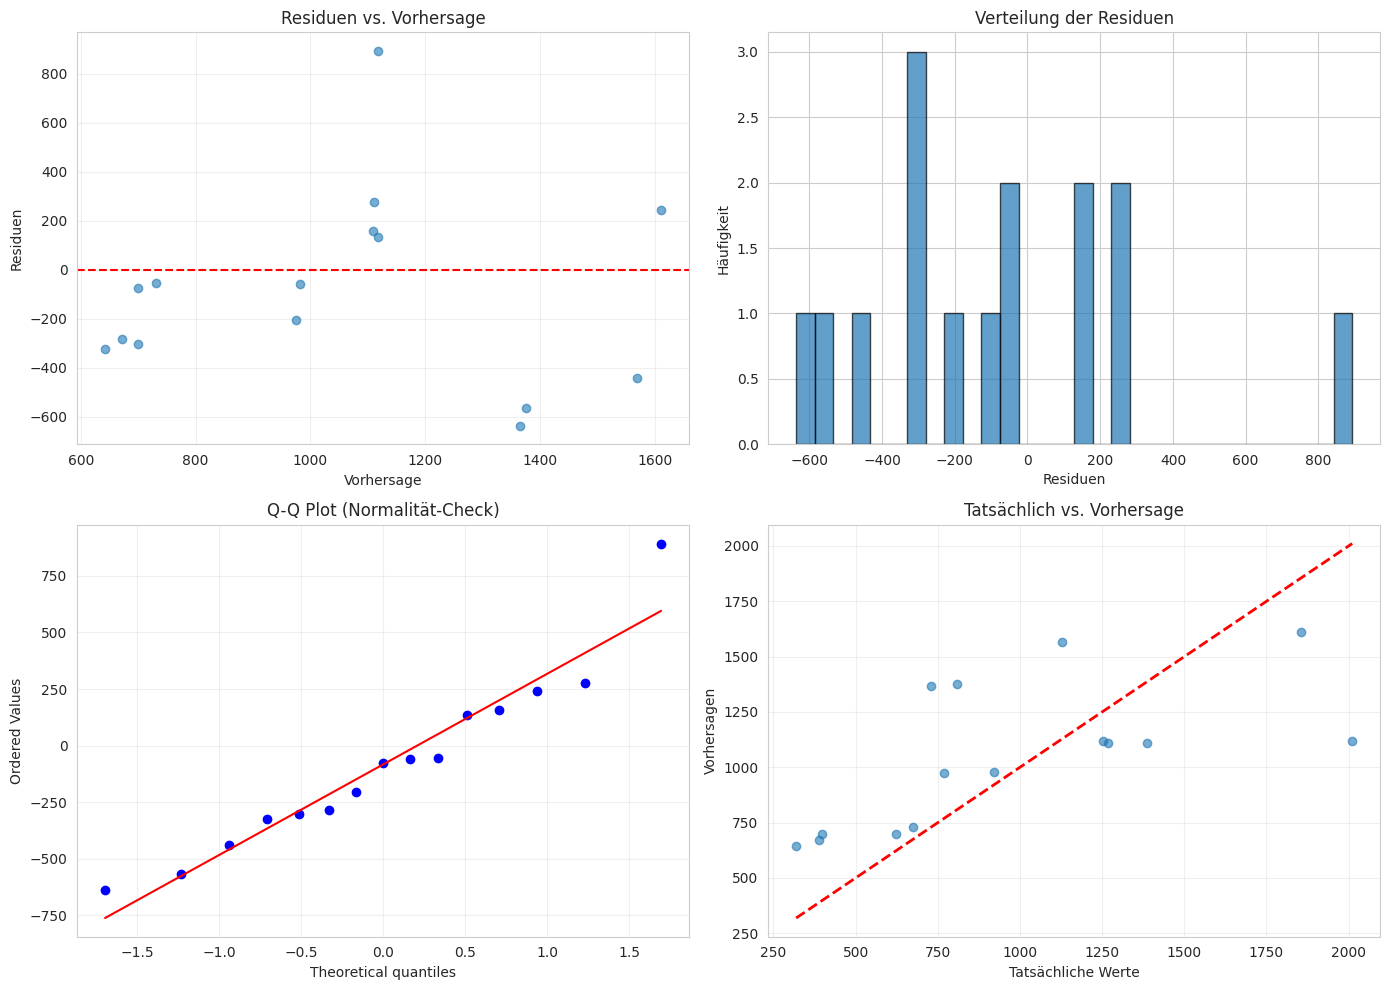



Residuenanalyse & Annahmenprüfung

Residuen-Statistik:
  Mittelwert: -82.986295 (sollte ≈ 0)
  Standardabweichung: 376.41
  Min: -636.21
  Max: 892.95

Shapiro-Wilk Normalitätstest:
  Statistik: 0.9399
  P-Wert: 3.8058e-01
  Normal verteilt: Ja (α=0.05)

Durbin-Watson Test (Autokorrelation):
  Statistik: 2.6002
  (Bereich 0-4, 2=keine Autokorrelation)

Residuenstreuung:
  Min: -636.21, Max: 892.95
  Range: 1529.16


In [11]:
# Nutze das beste Modell für Residuenanalyse
best_model = best_ridge_model
y_pred_best = best_ridge_model.predict(X_test)
residuals = y_test - y_pred_best

# Residuenplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Residuen vs. Vorhersage
axes[0, 0].scatter(y_pred_best, residuals, alpha=0.6)
axes[0, 0].axhline(y=0, color='r', linestyle='--')
axes[0, 0].set_xlabel('Vorhersage')
axes[0, 0].set_ylabel('Residuen')
axes[0, 0].set_title('Residuen vs. Vorhersage')
axes[0, 0].grid(True, alpha=0.3)

# 2. Histogramm der Residuen
axes[0, 1].hist(residuals, bins=30, edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Residuen')
axes[0, 1].set_ylabel('Häufigkeit')
axes[0, 1].set_title('Verteilung der Residuen')

# 3. Q-Q Plot
stats.probplot(residuals, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot (Normalität-Check)')
axes[1, 0].grid(True, alpha=0.3)

# 4. Tatsächlich vs. Vorhersage
axes[1, 1].scatter(y_test, y_pred_best, alpha=0.6)
axes[1, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1, 1].set_xlabel('Tatsächliche Werte')
axes[1, 1].set_ylabel('Vorhersagen')
axes[1, 1].set_title('Tatsächlich vs. Vorhersage')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*50 + "\n")

# Annahmenprüfung
print("Residuenanalyse & Annahmenprüfung")
print("="*50)
print(f"\nResiduen-Statistik:")
print(f"  Mittelwert: {residuals.mean():.6f} (sollte ≈ 0)")
print(f"  Standardabweichung: {residuals.std():.2f}")
print(f"  Min: {residuals.min():.2f}")
print(f"  Max: {residuals.max():.2f}")

# Normalitätstest (Shapiro-Wilk)
if len(residuals) <= 5000:  # Shapiro-Wilk hat Limit
    shapiro_stat, shapiro_p = stats.shapiro(residuals)
    print(f"\nShapiro-Wilk Normalitätstest:")
    print(f"  Statistik: {shapiro_stat:.4f}")
    print(f"  P-Wert: {shapiro_p:.4e}")
    print(f"  Normal verteilt: {'Ja' if shapiro_p > 0.05 else 'Nein'} (α=0.05)")

# Durbin-Watson Test (Autokorrelation)
dw_stat = sm.stats.durbin_watson(residuals)
print(f"\nDurbin-Watson Test (Autokorrelation):")
print(f"  Statistik: {dw_stat:.4f}")
print(f"  (Bereich 0-4, 2=keine Autokorrelation)")

# Breusch-Pagan Test (Heteroskedastizität) - simplified version
print(f"\nResiduenstreuung:")
print(f"  Min: {residuals.min():.2f}, Max: {residuals.max():.2f}")
print(f"  Range: {residuals.max() - residuals.min():.2f}")

## 11. Residuenanalyse & Annahmenprüfung

In diesem Abschnitt werden Residuen geplottet, ein QQ‑Plot erstellt und Durbin‑Watson sowie der Breusch‑Pagan‑Test durchgeführt, um Autokorrelation bzw. Heteroskedastizität zu prüfen.

Bestes Modell (laut Bewertung): Linear Regression


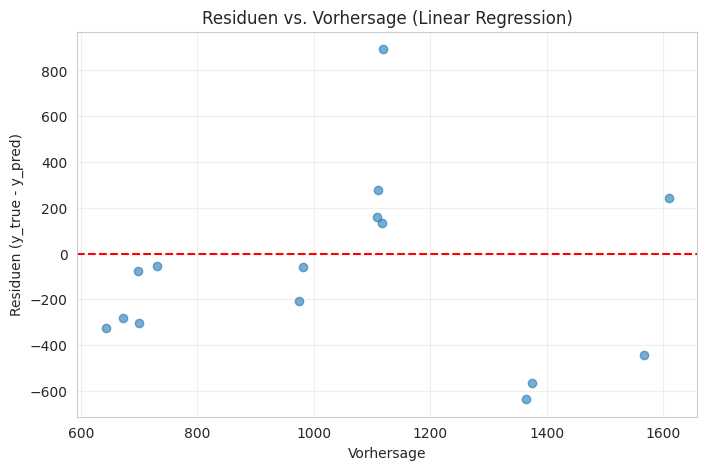

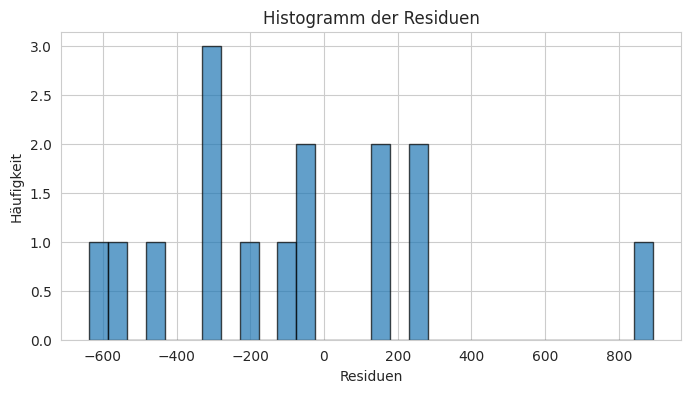

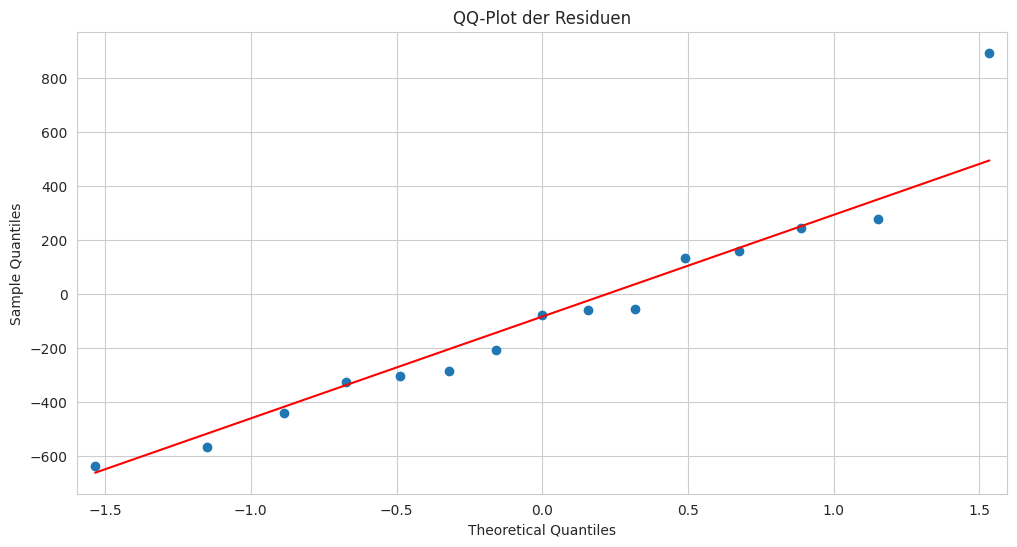

Durbin-Watson: 2.6002 (≈2 => keine Autokorrelation)
Breusch-Pagan LM-Statistik: 1.5418, p-value: 2.1435e-01
Breusch-Pagan F-Statistik: 1.4893, p-value: 2.4400e-01
Hinweis: Kleinere p-Werte deuten auf Heteroskedastizität hin.


In [12]:
# Bestes Modell automatisch wählen anhand R² in results_df
# Mappe Modellnamen auf Objekte und Vorhersagen
models_map = {
    'Linear Regression': (lr_model, y_pred_lr),
    f'Ridge (best, alpha={ridge_grid.best_params_["alpha"]})': (best_ridge_model, y_pred_ridge_best),
    f'Lasso (best, alpha={lasso_grid.best_params_["alpha"]})': (best_lasso_model, y_pred_lasso_best),
    'Ridge (alpha=1.0)': (ridge_model, y_pred_ridge),
    'Lasso (alpha=0.1)': (lasso_model, y_pred_lasso)
}

best_name = results_df.iloc[0]['Modell']
best_model, best_pred = models_map.get(best_name, (lr_model, y_pred_lr))
print(f"Bestes Modell (laut Bewertung): {best_name}")

# Residuen
residuals = y_test - best_pred

# Residuen vs. Vorhersage
plt.figure(figsize=(8,5))
plt.scatter(best_pred, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Vorhersage')
plt.ylabel('Residuen (y_true - y_pred)')
plt.title(f'Residuen vs. Vorhersage ({best_name})')
plt.grid(alpha=0.3)
plt.show()

# Histogramm der Residuen
plt.figure(figsize=(8,4))
plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
plt.title('Histogramm der Residuen')
plt.xlabel('Residuen')
plt.ylabel('Häufigkeit')
plt.show()

# QQ-Plot
sm.qqplot(residuals, line='s')
plt.title('QQ-Plot der Residuen')
plt.show()

# Durbin-Watson Test (Autokorrelation)
from statsmodels.stats.stattools import durbin_watson
dw = durbin_watson(residuals)
print(f"Durbin-Watson: {dw:.4f} (≈2 => keine Autokorrelation)")

# Breusch-Pagan Test auf Heteroskedastizität
from statsmodels.stats.diagnostic import het_breuschpagan
# Für BP-Test benötigen wir das Design-Matrix (inkl. Konstante)
X_train_const = sm.add_constant(X_test)
lm_stat, lm_pvalue, f_stat, f_pvalue = het_breuschpagan(residuals, X_train_const)
print(f"Breusch-Pagan LM-Statistik: {lm_stat:.4f}, p-value: {lm_pvalue:.4e}")
print(f"Breusch-Pagan F-Statistik: {f_stat:.4f}, p-value: {f_pvalue:.4e}")
print("Hinweis: Kleinere p-Werte deuten auf Heteroskedastizität hin.")

## 12. Modell speichern & Vorhersagen exportieren

Speichere das beste Modell mit `joblib` und exportiere Test‑Eingaben, tatsächliche Werte und Vorhersagen als CSV.

In [13]:
# Speichere bestes Modell
save_path = '/workspaces/ARM_Gruppe-5/best_model_regression.joblib'
joblib.dump(best_model, save_path)
print(f"Bestes Modell gespeichert unter: {save_path}")

# Erstelle DataFrame mit Testdaten, tatsächlichen Werten und Vorhersagen
preds_df = pd.DataFrame({
    'ds10680_endbestand': X_test.flatten(),
    'y_true_ds10200_quadratmeterpreis_chf': y_test,
    'y_pred': best_pred,
    'residual': y_test - best_pred
})

export_path = '/workspaces/ARM_Gruppe-5/exporte/predictions_regression.csv'
preds_df.to_csv(export_path, index=False)
print(f"Vorhersagen exportiert nach: {export_path}")

# Kurze Vorschau
preds_df.head()

Bestes Modell gespeichert unter: /workspaces/ARM_Gruppe-5/best_model_regression.joblib


OSError: Cannot save file into a non-existent directory: '/workspaces/ARM_Gruppe-5/exporte'